In [39]:
import rasterio as rio
import numpy as np
from glob import glob
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq, fftshift
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from scipy.stats import pearsonr
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from os.path import join, basename

In [44]:
import math
import cv2
import numpy as np


def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    From: https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def rotate_crop(image, i):
    a = rotate_image(image, i)
    a[a == 0] = np.nan
    a = a[~np.isnan(a).all(axis=1), :]
    a = a[:, ~np.isnan(a).all(axis=0)]

    if a.size > 0:
        b = np.sum(~np.isnan(a), axis = 1) == np.nanmedian(np.sum(~np.isnan(a), axis = 1))
        idx = np.argwhere(np.diff(np.r_[False, b, False]))
        if idx.size > 0:
            a = a[idx[0][0]:idx[-1][0], :]
            if a.size > 0:
                b = np.sum(~np.isnan(a), axis = 0) == np.nanmedian(np.sum(~np.isnan(a), axis = 0))
                idx = np.argwhere(np.diff(np.r_[False, b, False]))
                if idx.size > 0:
                    a = a[:, idx[0][0]:idx[-1][0]]
                    a[a==0] = np.nan
                    return a
    return None

def find_best_rotated(image):
    best_angle = None
    best_size = 0
    best_image = None
    for i in np.arange(0, 180, 0.5):
        a = rotate_crop(image, i)

        if a is not None:
                if best_size < a.size and np.sum(np.isnan(a)) == 0:
                    # print(f'New best rotation at {i} with size: {a.size}')
                    best_angle = i
                    best_size = a.size
                    best_image = a

    # f, (ax_orig, ax_rot, ax_crop, ax_sec) = plt.subplots(4,1)
    # ax_orig.imshow(image_orig)
    # ax_rot.imshow(image_rotated)
    # print(f'Best angle {best_angle} and size {best_size}')
    # ax_crop.imshow(best_image)
    # rot_sec = rotate_crop(sec_image, float(best_angle))
    # nans = np.sum(np.isnan(rot_sec))
    # print(f'Number of secondary nan {nans}')
    # ax_sec.imshow(rot_sec)
    if best_angle:
        print(f'Best angle {best_angle} and size {best_size}')
        plt.imshow(best_image)
        plt.show()
        return best_image
    else:
        print('No rotation found.')
        return None

def grid_interpolate(array):
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    return interpolate.griddata((x1, y1), newarr.ravel(),
                            (xx, yy), method='cubic')

Best angle 150.0 and size 7584


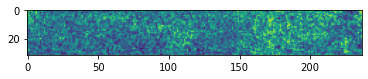

In [6]:
fp = glob('/bsuscratch/zacharykeskinen/data/uavsar/images/Lowman, CO/lowman_05208_21012-004_21015-009_0021d_s01_L090_01_int_grd/*.cor.grd.tiff')[0]
with rio.open(fp) as src:
    image = src.read(1)[::100,::100]
find_best_rotated(image)

In [50]:
from interpolate import grid_interpolate
from rotation_crop import find_best_rotated

/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT


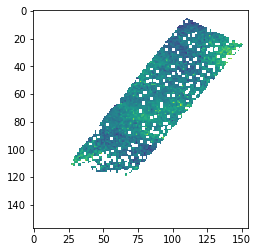

Best angle 39.0 and size 4715


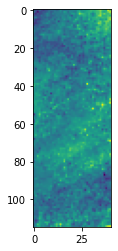

total pixels of final: 4715, filled 410. Percentage: 8.695652173913043
/bsuscratch/zacharykeskinen/data/uavsar/images/Eldorado National Forest, CA


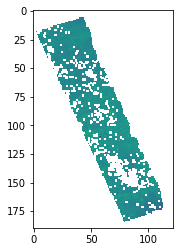

Best angle 67.0 and size 6408


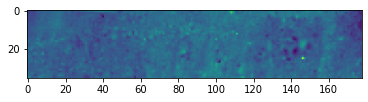

total pixels of final: 6408, filled 949. Percentage: 14.809612983770288
/bsuscratch/zacharykeskinen/data/uavsar/images/Donner Memorial State Park, CA


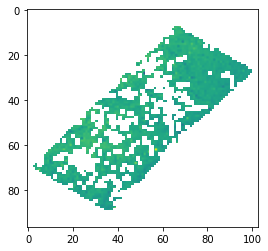

Best angle 135.5 and size 2960


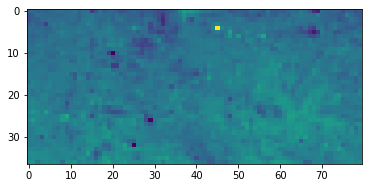

total pixels of final: 2960, filled 542. Percentage: 18.31081081081081
/bsuscratch/zacharykeskinen/data/uavsar/images/Rocky Mountains NP, CO


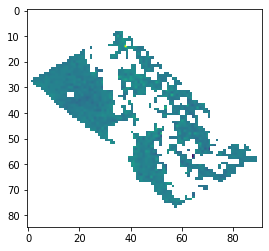

Best angle 41.0 and size 2304


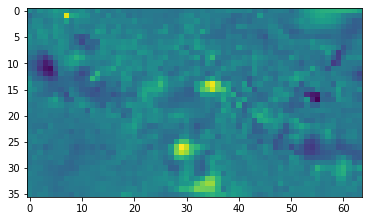

total pixels of final: 2304, filled 775. Percentage: 33.63715277777778
/bsuscratch/zacharykeskinen/data/uavsar/images/Grand Mesa, CO


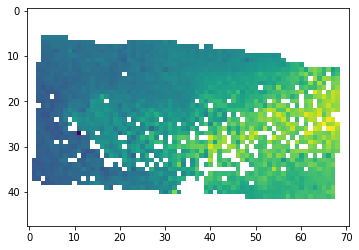

Best angle 5.0 and size 1755


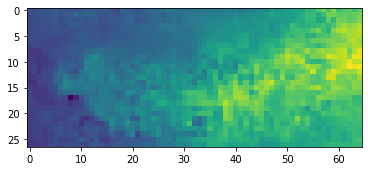

total pixels of final: 1755, filled 204. Percentage: 11.623931623931623
/bsuscratch/zacharykeskinen/data/uavsar/images/Sierra National Forest, CA


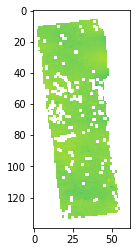

Best angle 82.5 and size 4464


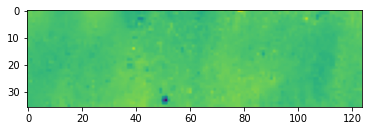

total pixels of final: 4464, filled 482. Percentage: 10.797491039426523
/bsuscratch/zacharykeskinen/data/uavsar/images/Fraser, CO


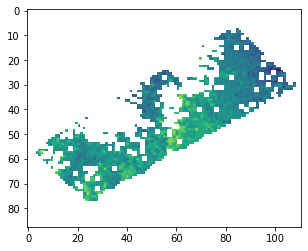

Best angle 150.0 and size 2610


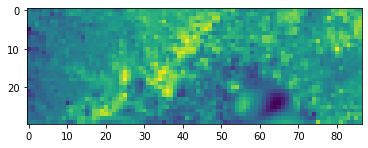

total pixels of final: 2610, filled 662. Percentage: 25.3639846743295
/bsuscratch/zacharykeskinen/data/uavsar/images/Peeler Peak, CO
/bsuscratch/zacharykeskinen/data/uavsar/images/Silver City, ID


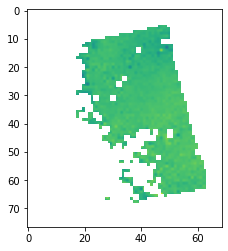

Best angle 76.5 and size 1881


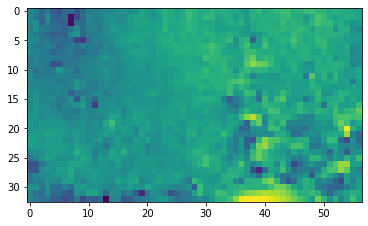

total pixels of final: 1881, filled 458. Percentage: 24.348750664540137
/bsuscratch/zacharykeskinen/data/uavsar/images/Ironton, CO
/bsuscratch/zacharykeskinen/data/uavsar/images/Los Alamos, NM


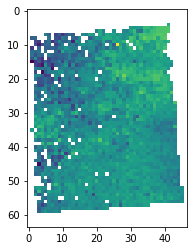

Best angle 86.5 and size 2000


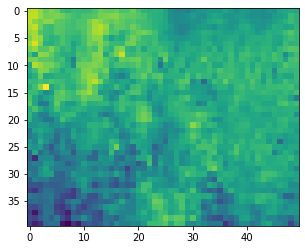

total pixels of final: 2000, filled 131. Percentage: 6.55
/bsuscratch/zacharykeskinen/data/uavsar/images/Lowman, CO


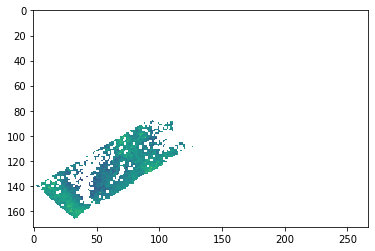

Best angle 59.0 and size 3024


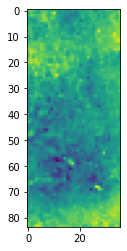

total pixels of final: 3024, filled 799. Percentage: 26.42195767195767
/bsuscratch/zacharykeskinen/data/uavsar/images/Salt Lake City, UT


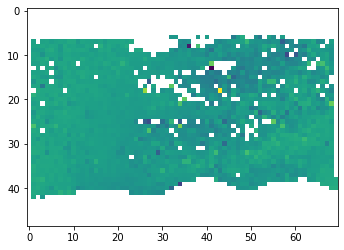

No rotation found.


In [48]:
locs = glob(join('/bsuscratch/zacharykeskinen/data/uavsar/images/','*'))
for loc in locs:
    print(loc)
    pairs = glob(join(loc, '*'))
    pair = [p for p in pairs if basename(p) != 'tmp'][0]
    images = glob(join(pair, '*'))
    images = [i for i in images if 'unw' in i]
    if images:
        image = images[0]
        with rio.open(image) as src:
            image = src.read(1)[::100,::100]
        nan_nonint = np.sum(np.isnan(image))
        plt.imshow(image)
        plt.show()
        image = grid_interpolate(image)
        nan_int = np.sum(np.isnan(image))
        number_filled = nan_nonint - nan_int
        best = find_best_rotated(image)
        if best is not None:
            print(f'total pixels of final: {best.size}, filled {number_filled}. Percentage: {100*number_filled/best.size}')
